### How Does Decision Tree Make a Split?
- Adopted from [this notebook](https://www.kaggle.com/code/kashnitsky/topic-3-decision-trees-and-knn)

In [19]:
import warnings
import numpy as np
import pandas as pd
import pydotplus  
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, export_graphviz

sns.set()
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings('ignore')

### Dataset Creation

In [4]:
# first class
np.random.seed(17)
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# second class
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]

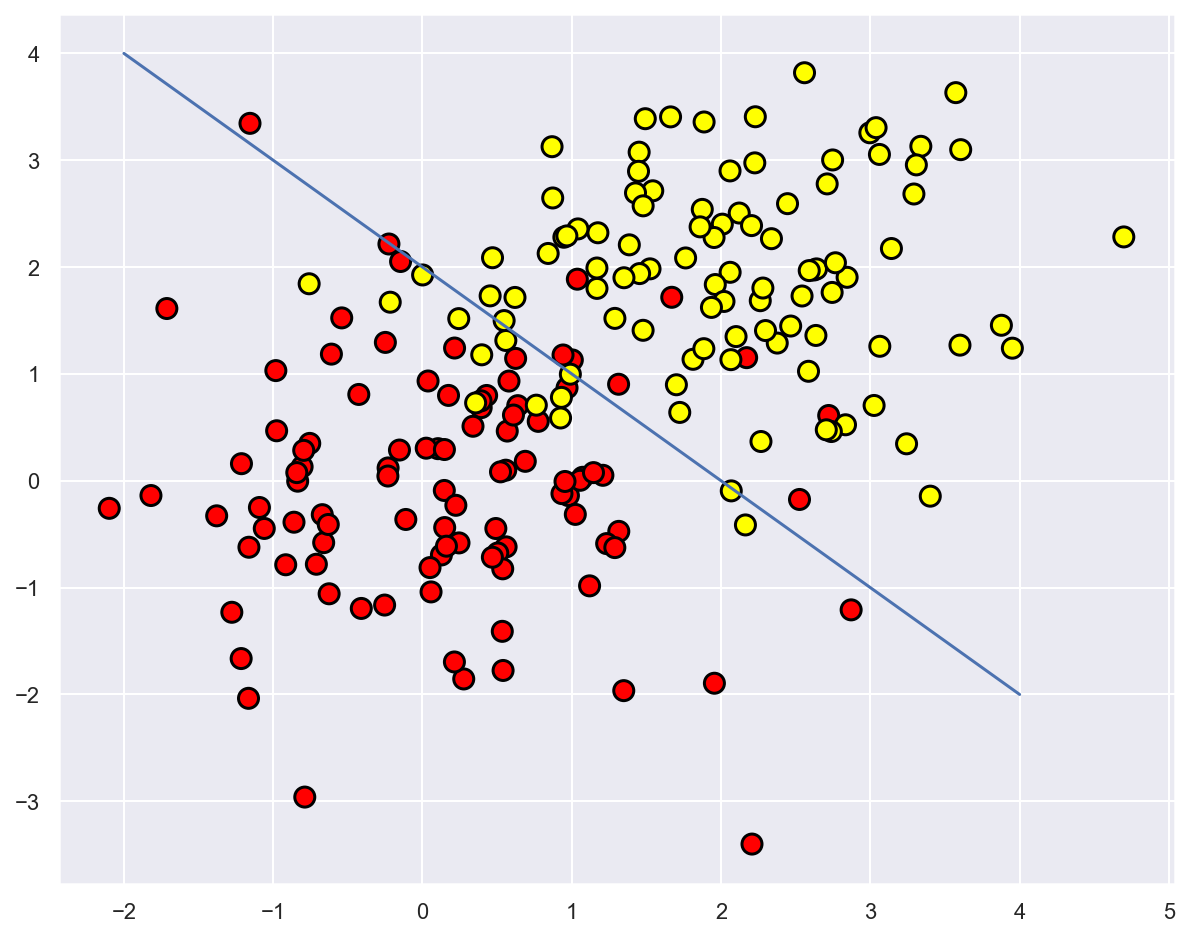

In [5]:
# visualize feature space
plt.figure(figsize=(10, 8))
plt.scatter(
    train_data[:, 0],
    train_data[:, 1],
    c=train_labels,
    s=100,
    cmap="autumn",
    edgecolors="black",
    linewidth=1.5,
)
plt.plot(range(-2, 5), range(4, -3, -1));

Let's try to separate these two classes by training an `Sklearn` decision tree. We will use max_depth parameter that limits the depth of the tree. Let's visualize the resulting separating boundary.

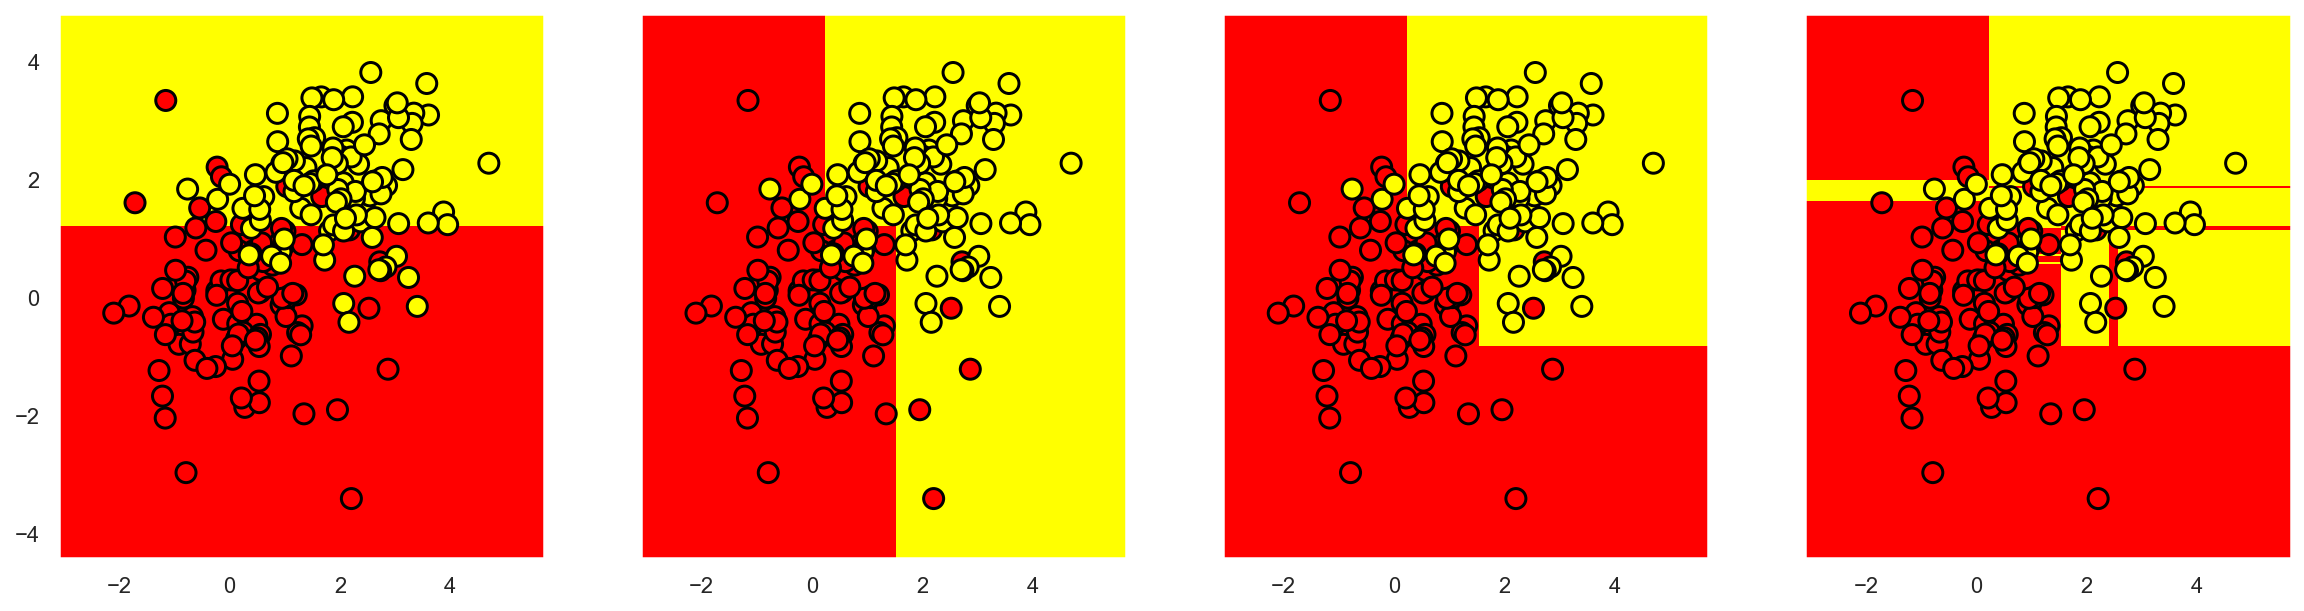

In [10]:
# let’s write an auxiliary function that will return grid for further visualization.
seed = 23

def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))


clf_tree_a = DecisionTreeClassifier(criterion="entropy", max_depth=1, random_state=seed)
clf_tree_b = DecisionTreeClassifier(criterion="entropy", max_depth=2, random_state=seed)
clf_tree_c = DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=seed)
clf_tree_d = DecisionTreeClassifier(criterion="entropy", max_depth=10, random_state=seed)

models= [
    clf_tree_a,
    clf_tree_b,
    clf_tree_c,
    clf_tree_d,
]

# training the tree
for model in models:
    model.fit(train_data, train_labels)


# visualize separation plot
_, axes = plt.subplots(1, 4, sharey=True, figsize=(20, 5))

for i, model in enumerate(models):
    xx, yy = get_grid(train_data)
    predicted = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    axes[i].pcolormesh(xx, yy, predicted, cmap="autumn")
    axes[i].scatter(
        train_data[:, 0],
        train_data[:, 1],
        c=train_labels,
        s=100,
        cmap="autumn",
        edgecolors="black",
        linewidth=1.5,
    );

- This is what decision boundaries we get from different decision trees
- Optimal number of depth is 3

### Tree Visualization

In [16]:
def tree_graph_to_png(tree, feature_names, png_file_to_save):
    """
    This requires GraphViz to be installed.  
    """
    
    tree_str = export_graphviz(
        tree, feature_names=feature_names, filled=True, out_file=None
    )
    graph = pydotplus.graph_from_dot_data(tree_str)
    graph.write_png(png_file_to_save)

In [18]:
# GraphViz issue
# tree_graph_to_png(
#     tree=clf_tree_c,
#     feature_names=["x1", "x2"],
#     png_file_to_save="topic3_decision_tree1.png",
# )

### How a Decision Tree Works with Numerical Features
Suppose we have a numeric feature "Age" that has a lot of unique values. A decision tree will look for the best (according to some criterion of information gain) split by checking binary attributes:
- `"Age <17"`
- `"Age < 22.87"`

and so on. But what if the age range is large? Or what if another quantitative variable, "salary", can also be "cut" in many ways? There will be too many binary attributes to select from at each step during tree construction. To resolve this problem, heuristics are usually used to limit the number of thresholds to which we compare the quantitative variable.

In [21]:
# Let's consider an example. Suppose we have the following dataset:
df = pd.DataFrame(
    {
        "Age": [17, 64, 18, 20, 38, 49, 55, 25, 29, 31, 33],
        "Loan Default": [1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1],
    }
)

# sort it by age in ascending order
df.sort_values("Age")

,Age,Loan Default
0,17,1
2,18,1
3,20,0
7,25,1
8,29,1
9,31,0
10,33,1
4,38,1
5,49,0
6,55,0


In [22]:
# # GraphViz issue
# age_tree = DecisionTreeClassifier(random_state=17)
# age_tree.fit(df["Age"].values.reshape(-1, 1), df["Loan Default"].values)

# tree_graph_to_png(
#     age_tree,
#     feature_names=["Age"],
#     png_file_to_save="topic3_decision_tree2.png",
# )

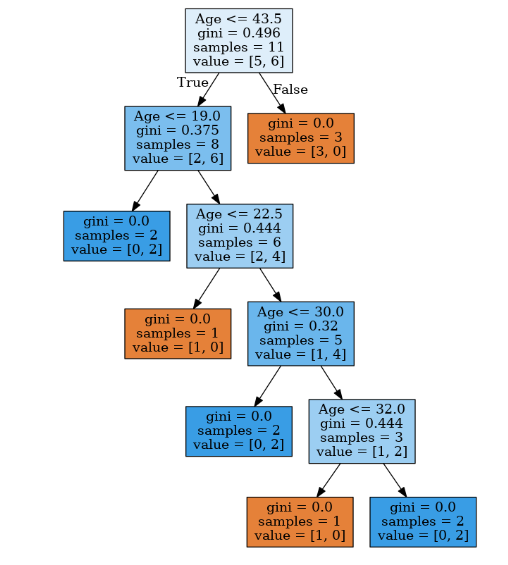

We see that the tree used the following 5 values to evaluate by age: 43.5, 19, 22.5, 30, and 32 years. If you look closely, these are exactly the mean values between the ages at which the target class "switches" from 1 to 0 or 0 to 1
- 43.5 is the average of 38 and 49 years;
- 38-year-old customer failed to return the loan whereas the 49-year-old did.

The **tree looks for the values at which the target class switches its value** as a threshold for "cutting" a quantitative variable.

In [23]:
# let's consider a more complex example by adding the "Salary" variable (in the thousands of dollars per year).
df_2 = pd.DataFrame(
    {
        "Age": [17, 64, 18, 20, 38, 49, 55, 25, 29, 31, 33],
        "Salary": [25, 80, 22, 36, 37, 59, 74, 70, 33, 102, 88],
        "Loan Default": [1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1],
    }
)

df_2.sort_values("Age")

,Age,Salary,Loan Default
0,17,25,1
2,18,22,1
3,20,36,0
7,25,70,1
8,29,33,1
9,31,102,0
10,33,88,1
4,38,37,1
5,49,59,0
6,55,74,0


In [24]:
# # GraphViz issue
# age_sal_tree = DecisionTreeClassifier(random_state=17)
# age_sal_tree.fit(df_2[["Age", "Salary"]].values, df_2["Loan Default"].values);

# tree_graph_to_png(
#     tree=age_sal_tree,
#     feature_names=["Age", "Salary"],
#     png_file_to_save="topic3_decision_tree3.png",
# )

- **Conclusion:** the simplest heuristics for handling numeric features in a decision tree is to sort its values in ascending order and check only those thresholds where the value of the target variable changes.